In [1]:
import sys
import random
import math
import itertools
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [2]:
random.seed(0)

In [3]:
df_training = pd.read_csv('../../datasets/titanic_training_processed.csv')
df_test = pd.read_csv('../../datasets/titanic_test_processed.csv')

This is just an experiment to practice with the concept of statistical distances. The idea is to visualise a dimensionality reduced representation of the two classes (survived / non-survived) to get some awarenenss of their separability and then use a simple Mahalanobis distance between each test observation and the two classes to perform classification in a 1-nearest neighbour kind of fashion. 

Originally I wanted to apply t-SNE for dimensionality reduction, but the t-SNE algorithm in scikit-learn cannot be applied to new data. Therefore, I am sticking with PCA instead. 

In [4]:
X = df_training.values[:, 2:]
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(X)

In [5]:
index_1 = df_training.Survived == 1
index_0 = df_training.Survived == 0

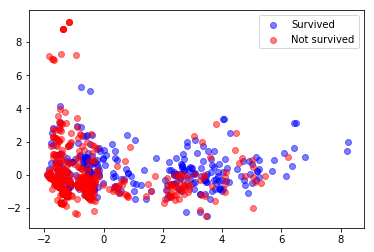

In [6]:
fig, ax = plt.subplots()
ax.scatter(X_pca[index_1, 0], X_pca[index_1, 1], c = 'blue', alpha = 0.5)
ax.scatter(X_pca[index_0, 0], X_pca[index_0, 1], c = 'red', alpha = 0.5)
_ = ax.legend(['Survived', 'Not survived'])

There seems to be a large overlap between the two distributions. What is the Bhattacharyya distance value?

In [7]:
def number_observations(array, x, y):
    return np.sum(np.logical_and(array[:, 0] < x, 
                                 np.logical_and(array[:, 0] >= x - 0.1, 
                                                np.logical_and(array[:, 1] < y, 
                                                               array[:, 1] >= y - 0.1))))

In [8]:
def bhattacharyya_distance(X_pca):
    discrete = np.arange(-30, 30, 0.1)
    n_1 = np.sum(index_1)
    n_0 = np.sum(index_0)
    bc = 0
    for i in list(itertools.product(discrete, discrete)):
        x = i[0]
        y = i[1]
        p_1 = number_observations(X_pca[index_1, :], x, y) / n_1
        p_0 = number_observations(X_pca[index_0, :], x, y) / n_0
        bc = bc + math.sqrt(p_1 * p_0)
    print('Bhattacharyya distance: ' + str(-math.log(bc)))
bhattacharyya_distance(X_pca)

Bhattacharyya distance: 1.2613423530397432


We are now using Mahalanobis distance to assign a class to each test observation. In order to do that, we need first to apply the same transforation that we applied to the traning data:

In [9]:
X_test_pca = pca.transform(df_test.values[:, 1:])

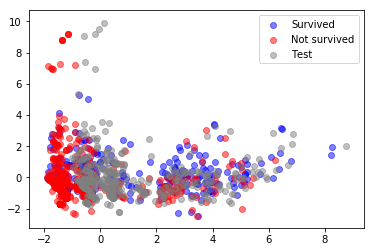

In [10]:
fig, ax = plt.subplots()
ax.scatter(X_pca[index_1, 0],  X_pca[index_1, 1], c = 'blue', alpha = 0.5)
ax.scatter(X_pca[index_0, 0], X_pca[index_0, 1], c = 'red', alpha = 0.5)
ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c = 'gray', alpha = 0.5)
_ = ax.legend(['Survived', 'Not survived', 'Test'])

And additionally we need to estimate the parameters of the two classes:

In [11]:
mean_0 = np.mean(X_pca[index_0, :], axis = 0)
mean_1 = np.mean(X_pca[index_1, :], axis = 0)
cov_0 = np.cov(X_pca[index_0, :].T)
cov_1 = np.cov(X_pca[index_1, :].T)

In [12]:
def mahalanobis(p, mean, cov):
    dif = p - mean
    return math.sqrt(np.dot(np.dot(dif.T, np.linalg.inv(cov)), dif))

In [13]:
y_test = []
for i in range(X_test_pca.shape[0]):
    dist_0 = mahalanobis(X_test_pca[i, :], mean_0, cov_0)
    dist_1 = mahalanobis(X_test_pca[i, :], mean_1, cov_1)
    y_test.append(int(dist_1 < dist_0))

In [14]:
submission = df_test.copy()
submission['Survived'] = y_test
submission = submission[['PassengerId', 'Survived']]

In [15]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [16]:
submission.to_csv('./submissions/03_mahalanobis.csv', index = False)

This submission achieved a 64.59% accuracy (much lower than the accuracy I got with logistic regression.) This method is not valid due to two factors: there is a large overlap between the two classes, and the distributions do not look like normal distributions. A similar but simpler approach, KNN, probably would have obtained a higher accuracy. 

## Feature selection

It is unlikely that we will improve the results much. However, just for the sake of the experiment, we are trying a feature selection approach (both forward selection and backward elimination). 

In [17]:
# generating sets for 10-fold cross validation
indexes = list(range(len(df_training)))
random.shuffle(indexes)
folds = []
for i in range(10):
    folds.append([])
for i in range(len(indexes)):
    folds[i % 10].append(indexes[i])

In [18]:
def produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes):
    columns = df_training.columns[column_indexes]
    datasets = {}
    datasets['X_train'] = df_training.iloc[train_indexes][columns].values
    datasets['X_test'] = df_training.iloc[test_indexes][columns].values
    datasets['y_train'] = df_training.iloc[train_indexes]['Survived'].values
    datasets['y_test'] = df_training.iloc[test_indexes]['Survived'].values
    
    return datasets

In [19]:
def evaluate(datasets):
    if datasets['X_train'].shape[1] > 2:
        pca = PCA(n_components = 2)
        X_training_pca = pca.fit_transform(datasets['X_train'])
        X_test_pca = pca.transform(datasets['X_test'])
    else:
        X_training_pca = datasets['X_train']
        X_test_pca = datasets['X_test']
        
    mean_0 = np.mean(X_training_pca[datasets['y_train'] == 0, :], axis = 0)
    mean_1 = np.mean(X_training_pca[datasets['y_train'] == 1, :], axis = 0)
    cov_0 = np.cov(X_training_pca[datasets['y_train'] == 0, :].T)
    cov_1 = np.cov(X_training_pca[datasets['y_train'] == 1, :].T)
    
    y_pred = []
    for i in range(X_test_pca.shape[0]):
        if datasets['X_train'].shape[1] > 1:
            dist_0 = mahalanobis(X_test_pca[i, :], mean_0, cov_0)
            dist_1 = mahalanobis(X_test_pca[i, :], mean_1, cov_1)
        else:
            dist_0 = (X_test_pca[i, :] - mean_0) / cov_0
            dist_1 = (X_test_pca[i, :] - mean_1) / cov_1
        y_pred.append(int(dist_1 < dist_0))
        
    return sqrt(np.sum(np.power(np.array(y_pred) - np.array(datasets['y_test']), 2)))

In [20]:
def k_fold_cross_validation(df_training, folds, column_indexes):
    error = 0
    
    for k in range(10):
        train_indexes = []
        for j in range(10):
            if j == k:
                test_indexes = folds[j]
            else:
                train_indexes = train_indexes + folds[j]
                
        datasets = produce_training_test_set(df_training, train_indexes, test_indexes, column_indexes)
        
        error = error + evaluate(datasets)
        
    return error / 10.0

In [21]:
column_indexes = list(range(2, 62))
k_fold_cross_validation(df_training, folds, column_indexes)

5.176219916392645

In [22]:
# Forward selection
pending = list(range(2, 62))
model = []
min_error = sys.float_info.max
while len(pending) > 0:
    
    prev_error = min_error
    min_error = sys.float_info.max
    
    for i in pending:
        new_model = model + [i]
        error = k_fold_cross_validation(df_training, folds, new_model)
        
        if error < min_error:
            min_error = error
            best_model = new_model
            feature = i
            
    if min_error < prev_error:
        print('Selecting feature ' + df_training.columns[feature] + ' - error decreased to ' + str(min_error))
        model = best_model
        pending.remove(feature)
    else:
        print('END')
        break

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in true_divide


Selecting feature Fare - error decreased to 5.719665280231709
Selecting feature Sex_male - error decreased to 4.510821340014385
Selecting feature TicketPrefix_A.5. - error decreased to 4.315884996964725
Selecting feature CabinClass_E - error decreased to 4.292871375658594
Selecting feature TicketPrefix_F.C. - error decreased to 4.2754215932685184
END


In [23]:
columns = df_training.columns[model]

pca = PCA(n_components = 2)
X_training_pca = pca.fit_transform(df_training[columns].values)
X_test_pca = pca.transform(df_test[columns].values)

mean_0 = np.mean(X_training_pca[index_0, :], axis = 0)
mean_1 = np.mean(X_training_pca[index_1, :], axis = 0)
cov_0 = np.cov(X_training_pca[index_0, :].T)
cov_1 = np.cov(X_training_pca[index_1, :].T)

y_pred = []
for i in range(X_test_pca.shape[0]):
    dist_0 = mahalanobis(X_test_pca[i, :], mean_0, cov_0)
    dist_1 = mahalanobis(X_test_pca[i, :], mean_1, cov_1)
    y_pred.append(int(dist_1 < dist_0))

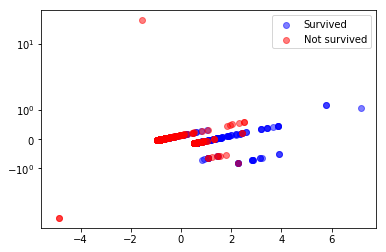

In [24]:
fig, ax = plt.subplots()
ax.scatter(X_training_pca[index_1, 0], X_training_pca[index_1, 1], c = 'blue', alpha = 0.5)
ax.scatter(X_training_pca[index_0, 0], X_training_pca[index_0, 1], c = 'red', alpha = 0.5)
ax.set_yscale('symlog')
_ = ax.legend(['Survived', 'Not survived', 'Test'])

In [25]:
bhattacharyya_distance(X_training_pca)

Bhattacharyya distance: 0.3450564467363329


In [26]:
submission = df_test.copy()
submission['Survived'] = y_pred
submission = submission[['PassengerId', 'Survived']]

In [27]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [28]:
submission.to_csv('./submissions/03_mahalanobis_forward_selection.csv', index = False)

This solution gets a prediction accuracy of 74.16%, which it quite close to my best logistic regression submission results (in spite of the fact that the classes seem to be less separable given the value of the Bhattacharyya distance)

In [29]:
# backward elimination
model = list(range(2, 62))
min_error = k_fold_cross_validation(df_training, folds, column_indexes)
while len(model) > 0:
    
    prev_error = min_error
    min_error = sys.float_info.max
    
    for i in model:
        new_model = model[:]
        new_model.remove(i)
        error = k_fold_cross_validation(df_training, folds, new_model)
        
        if error < min_error:
            min_error = error
            best_model = new_model
            feature = i
            
    if min_error < prev_error:
        print('Removing feature ' + df_training.columns[feature] + ' - error decreased to ' + str(min_error))
        model = best_model
    else:
        print('END')
        break

Removing feature Pclass_1 - error decreased to 5.110722695273216
Removing feature CabinClass_B - error decreased to 5.059834005358525
Removing feature TicketPrefix_W./C. - error decreased to 5.049731953915161
Removing feature CabinClass_G - error decreased to 5.037908203636425
Removing feature TicketPrefix_SC/AH - error decreased to 5.027366627287496
Removing feature TicketPrefix_PP - error decreased to 5.017051831062132
Removing feature TicketPrefix_SOTON/O.Q. - error decreased to 5.007516811119878
Removing feature CabinClass_A - error decreased to 4.997981791177623
END


In [30]:
columns = df_training.columns[model]

pca = PCA(n_components = 2)
X_training_pca = pca.fit_transform(df_training[columns].values)
X_test_pca = pca.transform(df_test[columns].values)

mean_0 = np.mean(X_training_pca[index_0, :], axis = 0)
mean_1 = np.mean(X_training_pca[index_1, :], axis = 0)
cov_0 = np.cov(X_training_pca[index_0, :].T)
cov_1 = np.cov(X_training_pca[index_1, :].T)

y_pred = []
for i in range(X_test_pca.shape[0]):
    dist_0 = mahalanobis(X_test_pca[i, :], mean_0, cov_0)
    dist_1 = mahalanobis(X_test_pca[i, :], mean_1, cov_1)
    y_pred.append(int(dist_1 < dist_0))

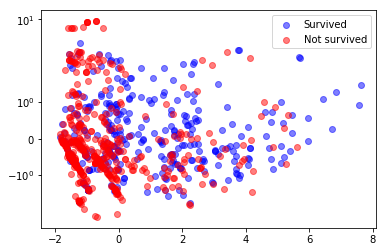

In [31]:
fig, ax = plt.subplots()
ax.scatter(X_training_pca[index_1, 0], X_training_pca[index_1, 1], c = 'blue', alpha = 0.5)
ax.scatter(X_training_pca[index_0, 0], X_training_pca[index_0, 1], c = 'red', alpha = 0.5)
ax.set_yscale('symlog')
_ = ax.legend(['Survived', 'Not survived', 'Test'])

In [32]:
bhattacharyya_distance(X_training_pca)

Bhattacharyya distance: 1.2240760366733605


In [33]:
submission = df_test.copy()
submission['Survived'] = y_pred
submission = submission[['PassengerId', 'Survived']]

In [34]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,0


In [35]:
submission.to_csv('./submissions/03_mahalanobis_backward_elimination.csv', index = False)

The prediction accuracty is better than that of the solution without feature selection, but significantly worse than the accuracy with forward selection: 61.72%. 

It is interesting to see how a simple approach can get such a close result to that of logistic regression. That makes me wonder how KNN is going to perform. 